In [ ]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

def collect_review_in_googlePlayStore(url, save_path, scroll_count):
    """
    구글 플레이 스토어 앱 리뷰 크롤링 함수.

    특정 앱의 리뷰 페이지를 열고 지정한 횟수만큼 스크롤을 내려
    모든 리뷰(작성자 ID, 별점, 작성일, 내용)를 수집한 뒤 CSV로 저장합니다.

    Args:
        url (str): 크롤링할 구글 플레이 스토어 앱 URL.
        save_path (str): 저장할 CSV 파일 경로.
        scroll_count (int): 리뷰 영역을 스크롤할 횟수 (많을수록 더 많은 리뷰 수집 가능).

    동작 순서:
        1. Selenium WebDriver로 크롬 브라우저 실행 후 해당 앱 URL 접속.
        2. "리뷰 더보기" 버튼 클릭.
        3. 리뷰 영역을 지정한 횟수만큼 스크롤 다운.
        4. 각 리뷰 요소에서 작성자, 별점, 날짜, 리뷰 내용을 추출.
        5. DataFrame으로 변환 후 전처리:
            - 별점: "별 5개 중 4개" → 정수 4로 변환
            - 날짜: "YYYY년 MM월 DD일" → datetime 형식 변환
        6. CSV 파일로 저장
        7. 크롬 브라우저 종료

    Example:
        collect_review_in_googlePlayStore(
            url="https://play.google.com/store/apps/details?id=com.woowahan.baeminmart&hl=ko",
            save_path="배민상회_리뷰.csv",
            scroll_count=5
        )

    주의사항:
        - 구글 플레이 UI 변경 시 CSS Selector 수정 필요.
        - 구글 플레이 UI가 다른 링크의 경우(게임, 베스트 앱 등) CSS Selector가 달라 동작하지 않을 수 있음
        - 리뷰가 많은 앱은 scroll_count 값을 크게 설정해야 충분히 수집 가능.
        - ChromeDriver 버전이 크롬 브라우저와 맞아야 함.
    """

    # Chrome 창 켜기
    driver = webdriver.Chrome()
    driver.maximize_window()

    # URL로 이동
    driver.get(url)

    # 평점 및 리뷰 더보기 클릭
    more_btn_css = "#yDmH0d > c-wiz.SSPGKf.Czez9d > div > div > div:nth-child(1) > div > div.wkMJlb.YWi3ub > div > div.qZmL0 > div:nth-child(1) > c-wiz:nth-child(5) > section > header > div > div:nth-child(2) > button > i"
    more_btn = driver.find_element(By.CSS_SELECTOR, more_btn_css)
    more_btn.click()

    time.sleep(2)

    # 스크롤 내리기
    rep = scroll_count
    display_box_css = "#yDmH0d > div.VfPpkd-Sx9Kwc.cC1eCc.UDxLd.PzCPDd.HQdjr.VfPpkd-Sx9Kwc-OWXEXe-FNFY6c > div.VfPpkd-wzTsW > div > div > div > div > div.fysCi.Vk3ZVd"
    display_box = driver.find_element(By.CSS_SELECTOR, display_box_css)
    for i in range(rep):
        display_box.send_keys(Keys.END)

    # 스크롤 맨 위로 움직이기
    display_box.send_keys(Keys.HOME)

    # 리뷰 추출하기
    review_css = "#yDmH0d > div.VfPpkd-Sx9Kwc.cC1eCc.UDxLd.PzCPDd.HQdjr.VfPpkd-Sx9Kwc-OWXEXe-FNFY6c > div.VfPpkd-wzTsW > div > div > div > div > div.fysCi.Vk3ZVd > div > div:nth-child(2) > div"
    reviews = driver.find_elements(By.CSS_SELECTOR, review_css)
    reviews

    # 모든 리뷰 수집하기
    data_list = []
    # 10개정도 수집되었을 때 프린트하기
    review_count = len(reviews)
    for i, review in enumerate(reviews):
        customer_id = review.find_element(By.CLASS_NAME,'X5PpBb').text
        star = review.find_element(By.CLASS_NAME, "iXRFPc").get_attribute("aria-label")
        enroll_date = review.find_element(By.CLASS_NAME, "bp9Aid").text
        content = review.find_element(By.CLASS_NAME, "h3YV2d").text

        review_dict = {
            "customer_id": customer_id,
            "star": star,
            "enroll_date" : enroll_date,
            "content" : content
        }
        if i % 10 == 0:
            print(f"{review_count}개 중에 {i}번째 리뷰를 수집 중입니다 ....")

        data_list.append(review_dict)

    # 크롬창 닫기    
    driver.quit()

    # 데이터프레임 만들기
    import pandas as pd
    data = pd.DataFrame(data = data_list)


    # 데이터프레임 별점에 대한 전처리
    data["star"] = data["star"].apply(lambda x: int(x[10]))


    # 데이터프레임 날짜 데이터타입 변경
    data["enroll_date"] = data["enroll_date"].apply(lambda x: pd.to_datetime(x, format="%Y년 %m월 %d일"))


    # csv파일로 저장하기
    data.to_csv(save_path)

collect_review_in_googlePlayStore(
    "https://play.google.com/store/apps/details?id=com.shinhan.o2o&hl=ko",
    "data/google_review_raw/구글플레이스토어_땡겨요_리뷰.csv", 5)

한국어 품사 태그 비교표:   
https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit?gid=0#gid=0

"""
    리뷰 데이터에서 전처리 및 형태소 분석을 수행하여 단어 리스트를 생성하는 함수.

    Args:
        data (pd.DataFrame): 'text' 컬럼에 리뷰 문자열이 포함된 데이터프레임.
        stopwords (list): 분석에서 제외할 불용어 리스트.

    Returns:
        list: 전처리 및 불용어 제거를 거친 명사 단어 리스트.

    동작 순서:
        1. 리뷰 텍스트에서 한글/영문/공백을 제외한 모든 특수문자 제거 (정규식 사용).
        2. Okt 형태소 분석기로 명사만 추출.
        3. 길이가 2글자 이상이고 불용어에 포함되지 않은 단어만 필터링.
        4. 필터링된 단어들을 하나의 리스트로 반환.

    Example:
        >>> import pandas as pd
        >>> df = pd.DataFrame({"text": ["배달이 빠르고 맛있어요", "쿠폰 할인이 많아요!"]})
        >>> stopwords = ["배달", "할인"]
        >>> get_word_list(df, stopwords)
        ['빠르', '맛있', '쿠폰', '많']

    Notes:
        - Okt 형태소 분석기의 `nouns` 메서드를 사용하여 명사만 추출.
        - 영어 단어도 포함되지만 특수문자는 제거됨.
        - 단어 길이 조건(len(word) > 1)로 1글자 명사는 필터링.
    """

In [1]:
import re
from konlpy.tag import Okt # 트위터

okt = Okt()

def get_word_list_with_okt(series, stopwords = [], pos_tags = []):
    word_list = []
    
    for i, text in enumerate(series.tolist()):
        # STEP1: 데이터 전처리
        new_text = re.sub("[^a-zA-Z가-힣\\s]", "", text)

        # STEP2: 형태소 분석
        result = okt.pos(new_text)

        # STEP3: 조건에 맞는 단어 담기
        for word, pos in result:
            if len(word) > 1 and word not in stopwords:
                if pos_tags == []:                
                    word_list.append(word)
                elif pos in pos_tags:
                    word_list.append(word)
        
    return word_list

In [2]:
import pandas as pd
data = pd.read_csv("data\google_review_raw\구글플레이스토어_땡겨요_리뷰.csv", index_col=0)
result = get_word_list_with_okt(data["content"], pos_tags = [])
print(result)

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\user\AppData\Local\Temp\ipykernel_7532\3620037651.py:2: SyntaxWarning: invalid escape sequence '\g'
  data = pd.read_csv("data\google_review_raw\구글플레이스토어_땡겨요_리뷰.csv", index_col=0)


['가입', '하고', '할인', '쿠폰', '주길래', '사용', '하려고', '하니', '할인', '쿠폰', '맞는', '결제', '수단', '선택', '라네', '다른', '결제', '안되고', '땡겨요', '페이', '간편', '결제', '가능하다네요', '좋아', '귀찮지만', '계좌', '카드', '등록', '하려고', '하니', '이번', '본인', '인증', '하라', '하고', '본인', '인증', '인증', '방법', '신한', '인증서', 'PASS', '인증', '쓰는데', '네이버', '인증', '이나', '휴대폰', '인증', '없나요', '이거야', '너무', '불편해서', '포기', '수수료', '확실히', '적어요', '경쟁', '배달', '비해', '가격', '낮게', '올라온', '경우', '많네요', '검색', '생겼지만', '결제', '시스템', '복잡합니다', '사용', '기기', '아닌', '유심', '없는', '보조', '에선', '인증', '안되는', '경우', '많아서', '결제', '수단', '등록', '어려워요', '주문', '가게', '화면', '에는', '배달', '시간', '이라고', '표시', '돼서', '주문', '하니까', '실제', '배달', '시간', '걸리네요', '전화해서', '물어보니', '다른', '배달', '집배', '달이니', '하면서', '빨리', '배달', '되는데', '땡겨', '요로', '주문', '하면', '우선', '순위', '밀리', '느릴수', '밖에', '없답니다', '심지어', '배달', '이나', '지불', '했는데도', '출시', '해서', '홍보', '하느라', '쿠폰', '지급', '많이', '하는것', '같은데', '배달', '속도', '생명', '입니다', '음식', '시키고', '시간', '넘게', '기다리면서', '기분', '좋게', '기다릴', '사람', '없어요', '다시는', '땡겨요', '사용', '할것', '같습니다', '가게', '까지의', '

In [ ]:
for i in range(3):
    for j in range(3):
        if j == 1:
            break
        print(i, j)

0 0
1 0
2 0


In [6]:
import pandas as pd
data = pd.read_csv("data\google_review_raw\구글플레이스토어_땡겨요_리뷰.csv", index_col=0)
result = get_word_list_grouped(data["content"], pos_tags = [])
print(result)
for re in result:
    print(re)

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\user\AppData\Local\Temp\ipykernel_7532\2980455436.py:2: SyntaxWarning: invalid escape sequence '\g'
  data = pd.read_csv("data\google_review_raw\구글플레이스토어_땡겨요_리뷰.csv", index_col=0)


[['가입', '하고', '할인', '쿠폰', '주길래', '사용', '하려고', '하니', '할인', '쿠폰', '에', '맞는', '결제', '수단', '을', '선택', '하', '라네', '다른', '결제', '는', '안되고', '땡겨요', '페이', '간편', '결제', '만', '가능하다네요', '좋아', '귀찮지만', '계좌', '나', '카드', '등록', '하려고', '하니', '이번', '엔', '본인', '인증', '을', '하라', '고', '하고', '본인', '인증', '인증', '방법', '은', '신한', '인증서', '와', 'PASS', '인증', '두', '개', '뿐', '난', '이', '거', '안', '쓰는데', '네이버', '인증', '이나', '휴대폰', '인증', '은', '없나요', '이거야', '원', '너무', '불편해서', '포기'], ['수수료', '가', '확실히', '적어요', '경쟁', '배달', '앱', '에', '비해', '가격', '이', '낮게', '올라온', '경우', '도', '많네요', '검색', '은', '생겼지만', '결제', '시스템', '이', '복잡합니다', '주', '사용', '기기', '가', '아닌', '유심', '없는', '보조', '폰', '에선', '인증', '이', '안되는', '경우', '가', '많아서', '결제', '수단', '등록', '이', '어려워요'], ['주문', '할', '때', '가게', '화면', '에는', '배달', '시간', '이', '분', '이라고', '표시', '돼서', '주문', '하니까', '실제', '배달', '은', '시간', '분', '걸리네요', '전화해서', '물어보니', '다른', '배달', '앱', '은', '한', '집배', '달이니', '뭐', '니', '하면서', '빨리', '배달', '되는데', '땡겨', '요로', '주문', '하면', '우선', '순위', '가', '밀리', '고', '느릴수', '밖에', '없

In [ ]:
import re
from konlpy.tag import Okt
from kiwipiepy import Kiwi

def get_word_list_flat(
        series, nlp_type = "okt", 
        stopwords = [], 
        pos_tags = []
    ):
    word_list = []
    
    nlp = Okt()
    if nlp_type == 'kiwi':
        nlp = Kiwi()
    
    for i, text in enumerate(series.tolist()):
        # STEP1: 데이터 전처리
        new_text = re.sub("[^a-zA-Z가-힣\\s]", "", text)

        # STEP2: 형태소 분석
        result = nlp.pos(new_text)

        # STEP3: 조건에 맞는 단어 담기
        for word, pos in result:
            # word의 길이가 min_len 보다 짧거나 불용어 포함시 넘어감
            if len(word) < 2 or word in stopwords:
                continue

            if pos_tags == []:                
                word_list.append(word)
            elif pos in pos_tags:
                word_list.append(word)
        
    return word_list

In [67]:
import re
from konlpy.tag import Okt
from kiwipiepy import Kiwi

def get_token_list(
    series,
    nlp_type = "okt",               # "okt" | "kiwi"
    stopwords = [],
    pos_tags = None,                # 예: ["Noun","Adjective"] (OKT) / ["NNG","NNP","VA"] (Kiwi)
    min_len = 2,                    # 최소 글자 수
    flatten = True                  # True: 1차원, False: 2차원(리뷰별)
):
    """
    텍스트 시리즈에서 전처리 → 형태소 분석 → (불용어, 품사, 길이) 필터 → 토큰 리스트 반환.

    Args:
        series: 문자열 iterable (예: df['text'])
        nlp_type: "okt" 또는 "kiwi"
        stopwords: 제외할 단어들
        pos_tags: 포함할 품사 태그 목록 (None/빈 리스트면 전 품사 허용)
            - OKT 예: ["Noun","Adjective"]
            - Kiwi 예: ["NNG","NNP","VA"]
        min_len: 최소 글자 수 필터
        flatten: True면 모든 리뷰 토큰을 하나의 리스트로 병합, False면 리뷰별 리스트 유지

    Returns:
        - flatten=True  -> List[str]
        - flatten=False -> List[List[str]]
    """
    word_list = []
    
    nlp = Okt()
    if nlp_type == 'kiwi':
        nlp = Kiwi()
    
    for i, text in enumerate(series.tolist()):
        # STEP1: 데이터 전처리
        new_text = re.sub("[^a-zA-Z가-힣\\s]", "", text)

        # STEP2: 형태소 분석
        result = nlp.pos(new_text)
    
        temp_list = []
        # STEP3: 조건에 맞는 단어 담기
        for word, pos in result:
            # word의 길이가 min_len 보다 짧거나 불용어 포함시 넘어감
            if len(word) < min_len or word in stopwords:
                continue

            if pos_tags == None:                
                temp_list.append(word)
            elif pos in pos_tags:
                temp_list.append(word)
        
        if flatten:
            word_list.extend(temp_list)
        else:
            word_list.append(temp_list)
        
    return word_list

In [68]:
import pandas as pd
data = pd.read_csv("data\google_review_raw\구글플레이스토어_땡겨요_리뷰.csv", index_col=0)
result = get_token_list(data["content"], flatten=True)
print(result)

['가입', '하고', '할인', '쿠폰', '주길래', '사용', '하려고', '하니', '할인', '쿠폰', '맞는', '결제', '수단', '선택', '라네', '다른', '결제', '안되고', '땡겨요', '페이', '간편', '결제', '가능하다네요', '좋아', '귀찮지만', '계좌', '카드', '등록', '하려고', '하니', '이번', '본인', '인증', '하라', '하고', '본인', '인증', '인증', '방법', '신한', '인증서', 'PASS', '인증', '쓰는데', '네이버', '인증', '이나', '휴대폰', '인증', '없나요', '이거야', '너무', '불편해서', '포기', '수수료', '확실히', '적어요', '경쟁', '배달', '비해', '가격', '낮게', '올라온', '경우', '많네요', '검색', '생겼지만', '결제', '시스템', '복잡합니다', '사용', '기기', '아닌', '유심', '없는', '보조', '에선', '인증', '안되는', '경우', '많아서', '결제', '수단', '등록', '어려워요', '주문', '가게', '화면', '에는', '배달', '시간', '이라고', '표시', '돼서', '주문', '하니까', '실제', '배달', '시간', '걸리네요', '전화해서', '물어보니', '다른', '배달', '집배', '달이니', '하면서', '빨리', '배달', '되는데', '땡겨', '요로', '주문', '하면', '우선', '순위', '밀리', '느릴수', '밖에', '없답니다', '심지어', '배달', '이나', '지불', '했는데도', '출시', '해서', '홍보', '하느라', '쿠폰', '지급', '많이', '하는것', '같은데', '배달', '속도', '생명', '입니다', '음식', '시키고', '시간', '넘게', '기다리면서', '기분', '좋게', '기다릴', '사람', '없어요', '다시는', '땡겨요', '사용', '할것', '같습니다', '가게', '까지의', '

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\user\AppData\Local\Temp\ipykernel_7532\290442135.py:2: SyntaxWarning: invalid escape sequence '\g'
  data = pd.read_csv("data\google_review_raw\구글플레이스토어_땡겨요_리뷰.csv", index_col=0)


In [69]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import koreanize_matplotlib
from PIL import Image 
import numpy as np 
from collections import Counter

def draw_wordcloud(word_list, 
                   most_common_count = -1, 
                   title = "wordcloud", 
                   font_path = "C:\Windodws\Fonts\malgun.ttf", 
                   image_path = "images/circle.png",
                   color_map = 'rainbow',
                   background_color = 'white'
                   ):
    """word_list를 받으면 Counter로 빈도 수를 센 후 워드 클라우드를 그리고 counter를 반환하는 함수"""
    counter = Counter(word_list)

    if most_common_count != -1:
        counter = counter.most_common(most_common_count)

    image = Image.open(image_path) # images/circle.png
    mask_img = np.array(image)
    
    wc = WordCloud(
        font_path = font_path, # C:\Windodws\Fonts\malgun.ttf
        mask=mask_img,
        background_color=background_color, # white
        colormap=color_map, # rainbow
        width=800,
        height=400
    )

    wc.generate_from_frequencies(counter)

    plt.figure(figsize=(5,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()

    return counter

<>:11: SyntaxWarning: invalid escape sequence '\W'
<>:11: SyntaxWarning: invalid escape sequence '\W'
C:\Users\user\AppData\Local\Temp\ipykernel_7532\2034298093.py:11: SyntaxWarning: invalid escape sequence '\W'
  font_path = "C:\Windodws\Fonts\malgun.ttf",


<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\user\AppData\Local\Temp\ipykernel_7532\1014623209.py:2: SyntaxWarning: invalid escape sequence '\g'
  data = pd.read_csv("data\google_review_raw\구글플레이스토어_땡겨요_리뷰.csv", index_col=0)


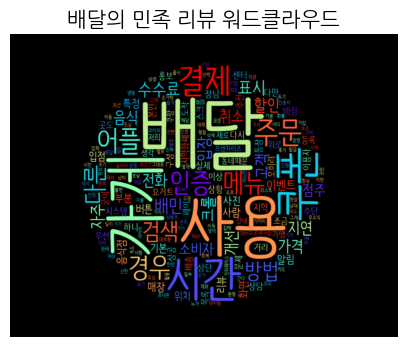

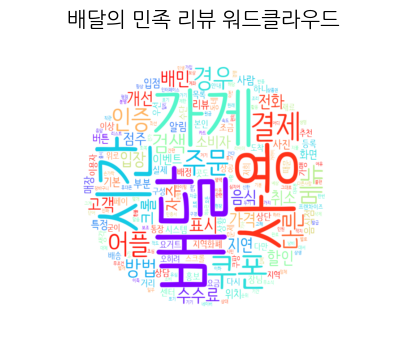

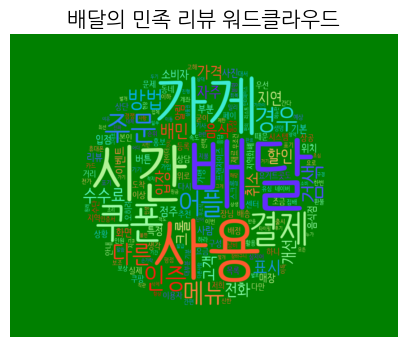

Counter({'배달': 26,
         '사용': 19,
         '가게': 17,
         '시간': 16,
         '쿠폰': 15,
         '결제': 11,
         '주문': 9,
         '어플': 8,
         '인증': 7,
         '경우': 7,
         '메뉴': 7,
         '다른': 6,
         '검색': 6,
         '방법': 5,
         '수수료': 5,
         '표시': 5,
         '배민': 5,
         '할인': 4,
         '가격': 4,
         '음식': 4,
         '지연': 4,
         '전화': 4,
         '취소': 4,
         '고객': 4,
         '크롤': 4,
         '입장': 4,
         '개선': 4,
         '자주': 4,
         '소비자': 4,
         '점주': 4,
         '이벤트': 4,
         '화면': 3,
         '사람': 3,
         '위치': 3,
         '기본': 3,
         '특정': 3,
         '사진': 3,
         '버튼': 3,
         '입점': 3,
         '매장': 3,
         '리뷰': 3,
         '부분': 3,
         '알림': 3,
         '음식점': 3,
         '하니': 2,
         '수단': 2,
         '페이': 2,
         '등록': 2,
         '본인': 2,
         '시스템': 2,
         '실제': 2,
         '우선': 2,
         '홍보': 2,
         '거리': 2,
         '이용자': 2

In [72]:
import pandas as pd
data = pd.read_csv("data\google_review_raw\구글플레이스토어_땡겨요_리뷰.csv", index_col=0)
result = get_token_list(data["content"], nlp_type='okt', pos_tags = ['Noun'])
draw_wordcloud(result, title="배달의 민족 리뷰 워드클라우드", font_path="fonts/NanumBarunpenR.ttf", background_color='black')
draw_wordcloud(result, title="배달의 민족 리뷰 워드클라우드", font_path="fonts/NanumBarunpenR.ttf", background_color='white')
draw_wordcloud(result, title="배달의 민족 리뷰 워드클라우드", font_path="fonts/NanumBarunpenR.ttf", background_color='green')